## L_04_1. Point cloud classification with GNN

The aim of the notebook is to illustrate how graph neural networks can be used for point cloud classification. See https://colab.research.google.com/drive/1D45E5bUK3gQ40YpZo65ozs7hg5l-eo_U?usp=sharing 

In [5]:
# Initialization. Functions for vizualization.
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_mesh(pos, face):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    # ax = fig.gca(projection='3d') # works on older version
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.axes.zaxis.set_ticklabels([])
    ax.plot_trisurf(pos[:, 0], pos[:, 1], pos[:, 2], triangles=data.face.t(), antialiased=False)
    plt.show()


def visualize_points(pos, edge_index=None, index=None):
    fig = plt.figure(figsize=(4, 4))
    if edge_index is not None:
        for (src, dst) in edge_index.t().tolist():
             src = pos[src].tolist()
             dst = pos[dst].tolist()
             plt.plot([src[0], dst[0]], [src[1], dst[1]], linewidth=1, color='black')
    if index is None:
        plt.scatter(pos[:, 0], pos[:, 1], s=50, zorder=1000)
    else:
       mask = torch.zeros(pos.size(0), dtype=torch.bool)
       mask[index] = True
       plt.scatter(pos[~mask, 0], pos[~mask, 1], s=50, color='lightgray', zorder=1000)
       plt.scatter(pos[mask, 0], pos[mask, 1], s=50, zorder=1000)
    plt.axis('off')
    plt.show()

In [3]:
!pip install torch_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 10.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=3da658883111cef902118bcddc52821ffc0d62657aef994d268d4a3f7acccf3c
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


GeometricShapes(40)
Data(pos=[32, 3], face=[3, 30], y=[1])


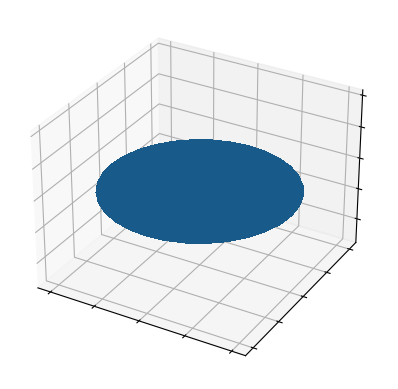

Data(pos=[16, 3], face=[3, 32], y=[1])


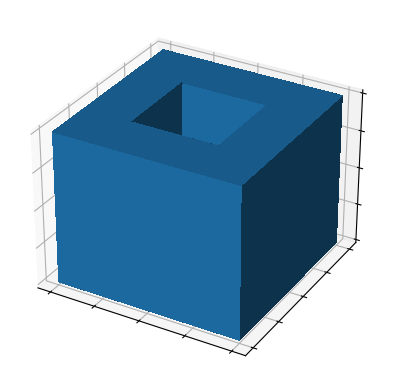

In [6]:
# Import data
from torch_geometric.datasets import GeometricShapes

dataset = GeometricShapes(root='data/GeometricShapes')
print(dataset)

data = dataset[0]
print(data)
visualize_mesh(data.pos, data.face)

data = dataset[11]
print(data)
visualize_mesh(data.pos, data.face)

Data(pos=[256, 3], y=[1])


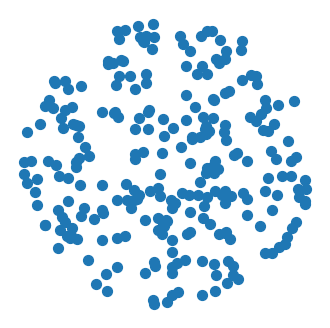

Data(pos=[256, 3], y=[1])


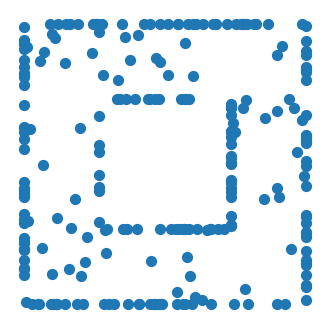

In [7]:
# Transform into point cloud
import torch
from torch_geometric.transforms import SamplePoints

torch.manual_seed(42)

dataset.transform = SamplePoints(num=256)

data = dataset[0]
print(data)
visualize_points(data.pos, data.edge_index)

data = dataset[11]
print(data)
visualize_points(data.pos)

In [24]:
# For Google Colab

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Found existing installation: torch-geometric 2.3.1
Uninstalling torch-geometric-2.3.1:
  Successfully uninstalled torch-geometric-2.3.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 20.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 20.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 16.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/py

torch.Size([2, 1536])


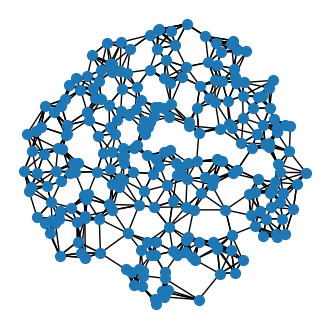

torch.Size([2, 1536])


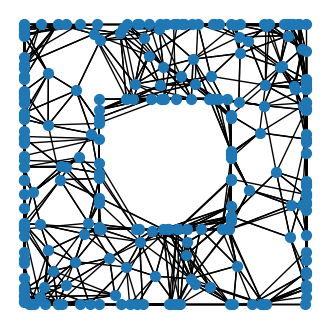

In [25]:
# Phase 1: grouping via graph generation
from torch_cluster import knn_graph

data = dataset[0]
data.edge_index = knn_graph(data.pos, k=6)
print(data.edge_index.shape)
visualize_points(data.pos, edge_index=data.edge_index)

data = dataset[11]
data.edge_index = knn_graph(data.pos, k=6)
print(data.edge_index.shape)
visualize_points(data.pos, edge_index=data.edge_index)

In [26]:
# Phase 2. Neighborhood Aggregation
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import MessagePassing


class PointNetLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        # Message passing with "max" aggregation.
        super(PointNetLayer, self).__init__('max')
        
        # Initialization of the MLP:
        # Here, the number of input features correspond to the hidden node
        # dimensionality plus point dimensionality (=3).
        self.mlp = Sequential(Linear(in_channels + 3, out_channels),
                              ReLU(),
                              Linear(out_channels, out_channels))
        
    def forward(self, h, pos, edge_index):
        # Start propagating messages.
        return self.propagate(edge_index, h=h, pos=pos)
    
    def message(self, h_j, pos_j, pos_i):
        # h_j defines the features of neighboring nodes as shape [num_edges, in_channels]
        # pos_j defines the position of neighboring nodes as shape [num_edges, 3]
        # pos_i defines the position of central nodes as shape [num_edges, 3]

        input = pos_j - pos_i  # Compute spatial relation.

        if h_j is not None:
            # In the first layer, we may not have any hidden node features,
            # so we only combine them in case they are present.
            input = torch.cat([h_j, input], dim=-1)

        return self.mlp(input)  # Apply our final MLP.

In [27]:
# Architecture of the network
import torch
import torch.nn.functional as F
from torch_cluster import knn_graph
from torch_geometric.nn import global_max_pool


class PointNet(torch.nn.Module):
    def __init__(self):
        super(PointNet, self).__init__()

        torch.manual_seed(12345)
        self.conv1 = PointNetLayer(3, 32)
        self.conv2 = PointNetLayer(32, 32)
        self.classifier = Linear(32, dataset.num_classes)
        
    def forward(self, pos, batch):
        # Compute the kNN graph:
        # Here, we need to pass the batch vector to the function call in order
        # to prevent creating edges between points of different examples.
        # We also add `loop=True` which will add self-loops to the graph in
        # order to preserve central point information.
        edge_index = knn_graph(pos, k=16, batch=batch, loop=True)
        
        # 3. Start bipartite message passing.
        h = self.conv1(h=pos, pos=pos, edge_index=edge_index)
        h = h.relu()
        h = self.conv2(h=h, pos=pos, edge_index=edge_index)
        h = h.relu()

        # 4. Global Pooling.
        h = global_max_pool(h, batch)  # [num_examples, hidden_channels]
        
        # 5. Classifier.
        return self.classifier(h)


model = PointNet()
print(model)

PointNet(
  (conv1): PointNetLayer()
  (conv2): PointNetLayer()
  (classifier): Linear(in_features=32, out_features=40, bias=True)
)


In [28]:
# Training and testing
from torch_geometric.data import DataLoader

train_dataset = GeometricShapes(root='data/GeometricShapes', train=True,
                                transform=SamplePoints(128))
test_dataset = GeometricShapes(root='data/GeometricShapes', train=False,
                               transform=SamplePoints(128))


train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10)

model = PointNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.

def train(model, optimizer, loader):
    model.train()
    
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()  # Clear gradients.
        logits = model(data.pos, data.batch)  # Forward pass.
        loss = criterion(logits, data.y)  # Loss computation.
        loss.backward()  # Backward pass.
        optimizer.step()  # Update model parameters.
        total_loss += loss.item() * data.num_graphs

    return total_loss / len(train_loader.dataset)


@torch.no_grad()
def test(model, loader):
    model.eval()

    total_correct = 0
    for data in loader:
        logits = model(data.pos, data.batch)
        pred = logits.argmax(dim=-1)
        total_correct += int((pred == data.y).sum())

    return total_correct / len(loader.dataset)

for epoch in range(1, 51):
    loss = train(model, optimizer, train_loader)
    test_acc = test(model, test_loader)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}')

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 01, Loss: 3.7549, Test Accuracy: 0.0500
Epoch: 02, Loss: 3.7011, Test Accuracy: 0.0250
Epoch: 03, Loss: 3.6830, Test Accuracy: 0.0250
Epoch: 04, Loss: 3.6705, Test Accuracy: 0.0250
Epoch: 05, Loss: 3.6338, Test Accuracy: 0.0250
Epoch: 06, Loss: 3.5937, Test Accuracy: 0.0250
Epoch: 07, Loss: 3.5599, Test Accuracy: 0.0250
Epoch: 08, Loss: 3.4820, Test Accuracy: 0.0500
Epoch: 09, Loss: 3.4096, Test Accuracy: 0.0500
Epoch: 10, Loss: 3.3637, Test Accuracy: 0.0500
Epoch: 11, Loss: 3.2883, Test Accuracy: 0.0750
Epoch: 12, Loss: 3.2181, Test Accuracy: 0.1000
Epoch: 13, Loss: 3.1262, Test Accuracy: 0.1500
Epoch: 14, Loss: 3.0487, Test Accuracy: 0.1750
Epoch: 15, Loss: 2.9215, Test Accuracy: 0.1750
Epoch: 16, Loss: 2.8044, Test Accuracy: 0.2000
Epoch: 17, Loss: 2.6913, Test Accuracy: 0.3500
Epoch: 18, Loss: 2.5293, Test Accuracy: 0.2750
Epoch: 19, Loss: 2.4080, Test Accuracy: 0.4250
Epoch: 20, Loss: 2.1689, Test Accuracy: 0.2750
Epoch: 21, Loss: 2.1438, Test Accuracy: 0.4000
Epoch: 22, Lo

Data(pos=[32, 3], face=[3, 30], y=[1])


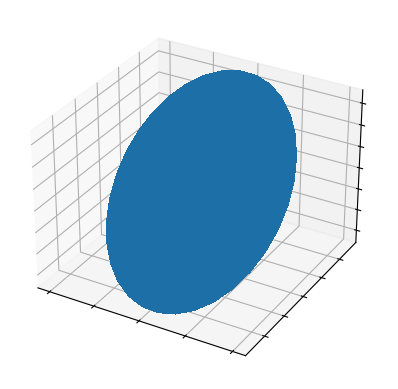

Data(pos=[4, 3], face=[3, 2], y=[1])


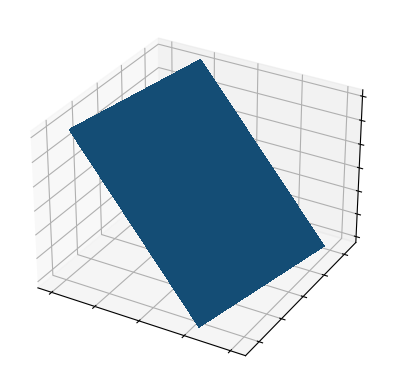

In [29]:
# Apply transformation to the data
from torch_geometric.transforms import Compose, RandomRotate

torch.manual_seed(123)

random_rotate = Compose([
    RandomRotate(degrees=90, axis=0),
    RandomRotate(degrees=90, axis=1),
    RandomRotate(degrees=90, axis=2),
])

dataset = GeometricShapes(root='data/GeometricShapes', transform=random_rotate)

data = dataset[0]
print(data)
visualize_mesh(data.pos, data.face)

data = dataset[4]
print(data)
visualize_mesh(data.pos, data.face)

In [42]:
# Test
torch.manual_seed(42)

transform = Compose([
    random_rotate,
    SamplePoints(num=128),
])

test_dataset = GeometricShapes(root='data/GeometricShapes', train=False,
                               transform=transform)

test_loader = DataLoader(test_dataset, batch_size=10)

test_acc = test(model, test_loader)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.2250
